## Imports

In [30]:
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load images and Data

In [2]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
images = [None for i in xrange(numImages)]
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName))
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values
labels=train_labels.tolist()
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)


test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

del images

In [3]:
#CNN train data
def img_norm(img):
    t= 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]
    return t
def minibatchData(data,labels_encoded,img_size,channel_num=3,batch_num=30):
    images=[]
    for img in data:
        if channel_num is 1:
            images.append(img_norm(cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),img_size)))
        else:
            images.append(np.transpose(img_norm(cv2.resize(img,img_size)),[2,0,1]))
        
        
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(images))
        print(batch_num)
        
        for i in range(int(len(images) / batch_num)):
            minibatch_d = images[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num,img_size[0],img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            if labels_encoded is not None:
                minibatch_l = labels_encoded[i*batch_num: (i+1)*batch_num]
                batch_labels.append(torch.LongTensor(minibatch_l))
            else:
                minibatch_l = np.zeros(batch_num)
                batch_labels.append(torch.LongTensor(minibatch_l))
        #data, labels = batch_data, batch_labels 
        
    return zip(batch_data, batch_labels)

In [6]:
le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)
Y_labels = np_utils.to_categorical(train_labels_encoded,99)

In [7]:
img_size=(224,224)
cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size))
#plt.imshow(cnn_train_data[0][0][3][0])

990
30


594
2
990
30
594
2


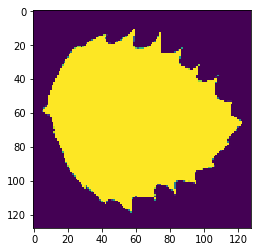

In [8]:
cnn_test_data = list(minibatchData(test_images,None,img_size,batch_num=2))
#print cnn_train_data.size
plt.imshow(cnn_test_data[0][0][1][0])

img_size_small=(128,128)
small_cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size_small,channel_num=1))
small_cnn_test_data = list(minibatchData(test_images,None,img_size_small,channel_num=1,batch_num=2))

plt.imshow(small_cnn_test_data[0][0][1][0])

## Define neural net architecture

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout=nn.Dropout(0.5)
        #self.conv3 = nn.Conv2d(32, 64, 4)
        self.fc1 = nn.Linear(32*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 99)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print x.shape
        x = self.pool(F.relu(self.conv2(x)))
        #print x.shape
        x=self.dropout(x)
        x = x.view(-1, 32*6*6)
        #print x.shape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print x.shape
        return x

In [10]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train neural net

In [11]:

start_time = time.time()
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i,data in enumerate(small_cnn_train_data,0):
        # get the inputs
        inputs, labels = data
        #print inputs
        #print inputs.shape
        optimizer_ft.zero_grad()
       # print inputs.type('torch.DoubleTensor')
        #inputs=inputs.type('torch.DoubleTensor')
        # forward + backward + optimize
        outputs = net(inputs)
        #print outputs.shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item()
        if i % 30 == 29:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 990))   
            running_loss = 0.0
end_time = time.time()

print('Finished Training in:',end_time-start_time)

[1,    30] loss: 0.139
[2,    30] loss: 0.139
[3,    30] loss: 0.139
[4,    30] loss: 0.139
[5,    30] loss: 0.139
[6,    30] loss: 0.139
[7,    30] loss: 0.139
[8,    30] loss: 0.139
[9,    30] loss: 0.139
[10,    30] loss: 0.139
[11,    30] loss: 0.139
[12,    30] loss: 0.139
[13,    30] loss: 0.139
[14,    30] loss: 0.139
[15,    30] loss: 0.139
[16,    30] loss: 0.139
[17,    30] loss: 0.139
[18,    30] loss: 0.139
[19,    30] loss: 0.138
[20,    30] loss: 0.138
[21,    30] loss: 0.138
[22,    30] loss: 0.138
[23,    30] loss: 0.138
[24,    30] loss: 0.137
[25,    30] loss: 0.137
[26,    30] loss: 0.136
[27,    30] loss: 0.135
[28,    30] loss: 0.133
[29,    30] loss: 0.131
[30,    30] loss: 0.128
[31,    30] loss: 0.126
[32,    30] loss: 0.122
[33,    30] loss: 0.116
[34,    30] loss: 0.112
[35,    30] loss: 0.105
[36,    30] loss: 0.101
[37,    30] loss: 0.096
[38,    30] loss: 0.092
[39,    30] loss: 0.088
[40,    30] loss: 0.087
[41,    30] loss: 0.083
[42,    30] loss: 0.079
[

In [12]:
small_probs_cnn_train=np.empty([0,99])
small_probs_cnn_test=np.empty([0,99])
sm = torch.nn.Softmax()
for data in small_cnn_train_data:
    images,labels=data
    small_probs_cnn_train=np.append(small_probs_cnn_train,sm(net(images)).data.numpy(),axis=0)
print small_probs_cnn_train.shape
    
for data in small_cnn_test_data:
    images, labels = data
    small_probs_cnn_test=np.append(small_probs_cnn_test,sm(net(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print small_probs_cnn_test.shape



/Users/anishsaha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(990, 99)


/Users/anishsaha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


(594, 99)


## Load saved pretrained AlexNet

In [14]:
filename='tunedAlex.sav'
model_ft = pickle.load(open(filename,'rb'))

In [15]:
probs_cnn_train=np.empty([0,99])
#sm = torch.nn.Softmax()
for data in cnn_train_data:
    images,labels=data
    probs_cnn_train=np.append(probs_cnn_train,(model_ft(images)).data.numpy(),axis=0)
print probs_cnn_train.shape
    

(990, 99)


In [16]:
probs_cnn_test=np.empty([0,99])
for data in cnn_test_data:
    images, labels = data
    probs_cnn_test=np.append(probs_cnn_test,(model_ft(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print probs_cnn_test.shape

#sm = torch.nn.Softmax()
#probabilities = sm(output) 
#print(probabilities)

(594, 99)


In [17]:
#separate the 3 histograms
train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

In [18]:
test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values

#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

## Compute descriptors, clusters and vocab

In [19]:
def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

In [20]:
des_start_time =time.time()
des_list_train = get_descriptor(train_images)

des_list_test = get_descriptor(test_images)
des_end_time =time.time()
print "Descriptors computed in {:2f} seconds".format(des_end_time-des_start_time)

Descriptors computed in 135.876172 seconds


In [21]:
clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 0.655427 seconds


In [22]:
vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

print vocab_train.shape

(990, 149)


In [23]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils import np_utils
import keras

## Define Keras model

In [24]:
deep_shape = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_texture = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_margin = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_sift = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_alex = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])

In [25]:
deep_shape.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_texture.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_margin.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_sift.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_alex.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])


In [26]:
print probs_cnn_train.shape
print Y_labels.shape
deep_alex.fit(probs_cnn_train,Y_labels,batch_size=16,epochs=150)
deep_shape.fit(train_shape_data,Y_labels,batch_size=16,epochs=150)
deep_texture.fit(train_texture_data,Y_labels,batch_size=16,epochs=150)
deep_margin.fit(train_margin_data,Y_labels,batch_size=16,epochs=150)
deep_sift.fit(vocab_train,Y_labels,batch_size=16,epochs=150)


deep_input = np.array(deep_shape.predict(train_shape_data))
deep_input = np.array(np.append(deep_input, deep_texture.predict(train_texture_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_margin.predict(train_margin_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_sift.predict(vocab_train), axis=1))
deep_input = np.array(np.append(deep_input, deep_alex.predict(probs_cnn_train), axis=1))
deep_input = np.array(np.append(deep_input, small_probs_cnn_train, axis=1))



# deep_final.fit(deep_input,Y_labels,batch_size=16,epochs=50)


(990, 99)
(990, 99)
Epoch 1/150
990/990 [==============================] - 1s 1ms/step - loss: 5.0683
Epoch 2/150
990/990 [==============================] - 0s 294us/step - loss: 2.6370
Epoch 3/150
990/990 [==============================] - 0s 292us/step - loss: 1.5924
Epoch 4/150
990/990 [==============================] - 0s 284us/step - loss: 1.0434
Epoch 5/150
990/990 [==============================] - 0s 284us/step - loss: 0.7516
Epoch 6/150
990/990 [==============================] - 0s 296us/step - loss: 0.6434
Epoch 7/150
990/990 [==============================] - 0s 283us/step - loss: 0.5290
Epoch 8/150
990/990 [==============================] - 0s 288us/step - loss: 0.4260
Epoch 9/150
990/990 [==============================] - 0s 289us/step - loss: 0.3686
Epoch 10/150
990/990 [==============================] - 0s 292us/step - loss: 0.3618
Epoch 11/150
990/990 [==============================] - 0s 294us/step - loss: 0.3145
Epoch 12/150
990/990 [==============================] - 

990/990 [==============================] - 0s 287us/step - loss: 0.0780
Epoch 98/150
990/990 [==============================] - 0s 288us/step - loss: 0.1099
Epoch 99/150
990/990 [==============================] - 0s 282us/step - loss: 0.0974
Epoch 100/150
990/990 [==============================] - 0s 281us/step - loss: 0.0929
Epoch 101/150
990/990 [==============================] - 0s 283us/step - loss: 0.1066
Epoch 102/150
990/990 [==============================] - 0s 281us/step - loss: 0.0652
Epoch 103/150
990/990 [==============================] - 0s 282us/step - loss: 0.1114
Epoch 104/150
990/990 [==============================] - 0s 281us/step - loss: 0.1135
Epoch 105/150
990/990 [==============================] - 0s 284us/step - loss: 0.0705
Epoch 106/150
990/990 [==============================] - 0s 281us/step - loss: 0.0347
Epoch 107/150
990/990 [==============================] - 0s 289us/step - loss: 0.0600
Epoch 108/150
990/990 [==============================] - 0s 293us/step

990/990 [==============================] - 0s 284us/step - loss: 3.6967
Epoch 44/150
990/990 [==============================] - 0s 284us/step - loss: 3.6988
Epoch 45/150
990/990 [==============================] - 0s 277us/step - loss: 3.7050
Epoch 46/150
990/990 [==============================] - 0s 280us/step - loss: 3.6678
Epoch 47/150
990/990 [==============================] - 0s 278us/step - loss: 3.6984
Epoch 48/150
990/990 [==============================] - 0s 276us/step - loss: 3.7004
Epoch 49/150
990/990 [==============================] - 0s 278us/step - loss: 3.6784
Epoch 50/150
990/990 [==============================] - 0s 279us/step - loss: 3.6753
Epoch 51/150
990/990 [==============================] - 0s 276us/step - loss: 3.6420
Epoch 52/150
990/990 [==============================] - 0s 278us/step - loss: 3.6519
Epoch 53/150
990/990 [==============================] - 0s 280us/step - loss: 3.6636
Epoch 54/150
990/990 [==============================] - 0s 278us/step - loss: 

990/990 [==============================] - 0s 347us/step - loss: 3.5106
Epoch 140/150
990/990 [==============================] - 0s 310us/step - loss: 3.5284
Epoch 141/150
990/990 [==============================] - 0s 281us/step - loss: 3.5205
Epoch 142/150
990/990 [==============================] - 0s 304us/step - loss: 3.5176
Epoch 143/150
990/990 [==============================] - 0s 286us/step - loss: 3.4953
Epoch 144/150
990/990 [==============================] - 0s 278us/step - loss: 3.5068
Epoch 145/150
990/990 [==============================] - 0s 278us/step - loss: 3.5226
Epoch 146/150
990/990 [==============================] - 0s 286us/step - loss: 3.4786
Epoch 147/150
990/990 [==============================] - 0s 278us/step - loss: 3.5287
Epoch 148/150
990/990 [==============================] - 0s 295us/step - loss: 3.4854
Epoch 149/150
990/990 [==============================] - 0s 292us/step - loss: 3.5109
Epoch 150/150
990/990 [==============================] - 0s 292us/st

990/990 [==============================] - 0s 279us/step - loss: 0.4419
Epoch 86/150
990/990 [==============================] - 0s 280us/step - loss: 0.4274
Epoch 87/150
990/990 [==============================] - 0s 278us/step - loss: 0.4164
Epoch 88/150
990/990 [==============================] - 0s 278us/step - loss: 0.4006
Epoch 89/150
990/990 [==============================] - 0s 278us/step - loss: 0.4075
Epoch 90/150
990/990 [==============================] - 0s 284us/step - loss: 0.4276
Epoch 91/150
990/990 [==============================] - 0s 283us/step - loss: 0.3993
Epoch 92/150
990/990 [==============================] - 0s 278us/step - loss: 0.3901
Epoch 93/150
990/990 [==============================] - 0s 278us/step - loss: 0.3837
Epoch 94/150
990/990 [==============================] - 0s 278us/step - loss: 0.3788
Epoch 95/150
990/990 [==============================] - 0s 278us/step - loss: 0.3884
Epoch 96/150
990/990 [==============================] - 0s 278us/step - loss: 

990/990 [==============================] - 0s 283us/step - loss: 1.1012
Epoch 32/150
990/990 [==============================] - 0s 279us/step - loss: 1.0994
Epoch 33/150
990/990 [==============================] - 0s 278us/step - loss: 1.0811
Epoch 34/150
990/990 [==============================] - 0s 280us/step - loss: 1.0438
Epoch 35/150
990/990 [==============================] - 0s 284us/step - loss: 1.0274
Epoch 36/150
990/990 [==============================] - 0s 283us/step - loss: 1.0461
Epoch 37/150
990/990 [==============================] - 0s 393us/step - loss: 1.0343
Epoch 38/150
990/990 [==============================] - 0s 347us/step - loss: 0.9924
Epoch 39/150
990/990 [==============================] - 0s 342us/step - loss: 0.9838
Epoch 40/150
990/990 [==============================] - 0s 341us/step - loss: 0.9620
Epoch 41/150
990/990 [==============================] - 0s 346us/step - loss: 0.9841
Epoch 42/150
990/990 [==============================] - 0s 343us/step - loss: 

990/990 [==============================] - 0s 282us/step - loss: 0.4691
Epoch 128/150
990/990 [==============================] - 0s 280us/step - loss: 0.4762
Epoch 129/150
990/990 [==============================] - 0s 279us/step - loss: 0.4394
Epoch 130/150
990/990 [==============================] - 0s 281us/step - loss: 0.4614
Epoch 131/150
990/990 [==============================] - 0s 282us/step - loss: 0.4663
Epoch 132/150
990/990 [==============================] - 0s 279us/step - loss: 0.4368
Epoch 133/150
990/990 [==============================] - 0s 280us/step - loss: 0.4184
Epoch 134/150
990/990 [==============================] - 0s 281us/step - loss: 0.4437
Epoch 135/150
990/990 [==============================] - 0s 284us/step - loss: 0.4768
Epoch 136/150
990/990 [==============================] - 0s 280us/step - loss: 0.4246
Epoch 137/150
990/990 [==============================] - 0s 282us/step - loss: 0.4283
Epoch 138/150
990/990 [==============================] - 0s 279us/st

990/990 [==============================] - 0s 316us/step - loss: 0.1470
Epoch 74/150
990/990 [==============================] - 0s 318us/step - loss: 0.1448
Epoch 75/150
990/990 [==============================] - 0s 319us/step - loss: 0.1440
Epoch 76/150
990/990 [==============================] - 0s 316us/step - loss: 0.1529
Epoch 77/150
990/990 [==============================] - 0s 313us/step - loss: 0.1523
Epoch 78/150
990/990 [==============================] - 0s 314us/step - loss: 0.1388
Epoch 79/150
990/990 [==============================] - 0s 320us/step - loss: 0.1295
Epoch 80/150
990/990 [==============================] - 0s 315us/step - loss: 0.1285
Epoch 81/150
990/990 [==============================] - 0s 317us/step - loss: 0.1304
Epoch 82/150
990/990 [==============================] - 0s 313us/step - loss: 0.1095
Epoch 83/150
990/990 [==============================] - 0s 318us/step - loss: 0.1231
Epoch 84/150
990/990 [==============================] - 0s 319us/step - loss: 

In [27]:
# deep_model = Sequential([
#     Dense(512, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dropout(0.4),
#     Dense(256, activation='relu'),
#     Dense(99, activation='softmax')
# ])

deep_model = Sequential([
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(99, activation='softmax')
])

deep_model.compile(loss='categorical_crossentropy',optimizer='adam',metric=[keras.metrics.categorical_accuracy])

## Train model

In [28]:
deep_model.fit(deep_input,Y_labels,batch_size=32,epochs=200, validation_split=0.2)
deep_model.summary()

Train on 792 samples, validate on 198 samples
Epoch 1/200
792/792 [==============================] - 2s 2ms/step - loss: 4.1596 - val_loss: 3.4617
Epoch 2/200
792/792 [==============================] - 0s 598us/step - loss: 2.1285 - val_loss: 1.0078
Epoch 3/200
792/792 [==============================] - 0s 605us/step - loss: 0.2289 - val_loss: 0.0540
Epoch 4/200
792/792 [==============================] - 0s 589us/step - loss: 0.0204 - val_loss: 0.0149
Epoch 5/200
792/792 [==============================] - 0s 596us/step - loss: 0.0093 - val_loss: 0.0096
Epoch 6/200
792/792 [==============================] - 0s 592us/step - loss: 0.0066 - val_loss: 0.0073
Epoch 7/200
792/792 [==============================] - 0s 594us/step - loss: 0.0052 - val_loss: 0.0057
Epoch 8/200
792/792 [==============================] - 0s 612us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 9/200
792/792 [==============================] - 0s 610us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/200
792/792 [=======

792/792 [==============================] - 0s 600us/step - loss: 7.9769e-05 - val_loss: 8.0610e-05
Epoch 76/200
792/792 [==============================] - 0s 587us/step - loss: 8.0456e-05 - val_loss: 7.8128e-05
Epoch 77/200
792/792 [==============================] - 1s 642us/step - loss: 7.8241e-05 - val_loss: 7.5620e-05
Epoch 78/200
792/792 [==============================] - 0s 594us/step - loss: 7.2059e-05 - val_loss: 7.3558e-05
Epoch 79/200
792/792 [==============================] - 0s 593us/step - loss: 6.9434e-05 - val_loss: 7.1392e-05
Epoch 80/200
792/792 [==============================] - 0s 602us/step - loss: 7.1824e-05 - val_loss: 6.9655e-05
Epoch 81/200
792/792 [==============================] - 0s 609us/step - loss: 6.8942e-05 - val_loss: 6.7743e-05
Epoch 82/200
792/792 [==============================] - 0s 603us/step - loss: 7.4259e-05 - val_loss: 6.5792e-05
Epoch 83/200
792/792 [==============================] - 0s 595us/step - loss: 6.5892e-05 - val_loss: 6.4118e-05
Epoch

Epoch 148/200
792/792 [==============================] - 0s 601us/step - loss: 1.7362e-05 - val_loss: 1.5330e-05
Epoch 149/200
792/792 [==============================] - 0s 610us/step - loss: 1.8266e-05 - val_loss: 1.5081e-05
Epoch 150/200
792/792 [==============================] - 1s 639us/step - loss: 1.6887e-05 - val_loss: 1.4784e-05
Epoch 151/200
792/792 [==============================] - 0s 610us/step - loss: 1.7269e-05 - val_loss: 1.4458e-05
Epoch 152/200
792/792 [==============================] - 0s 604us/step - loss: 1.5846e-05 - val_loss: 1.4224e-05
Epoch 153/200
792/792 [==============================] - 0s 597us/step - loss: 1.5594e-05 - val_loss: 1.3978e-05
Epoch 154/200
792/792 [==============================] - 0s 588us/step - loss: 1.6167e-05 - val_loss: 1.3769e-05
Epoch 155/200
792/792 [==============================] - 0s 589us/step - loss: 1.5462e-05 - val_loss: 1.3535e-05
Epoch 156/200
792/792 [==============================] - 0s 587us/step - loss: 1.4465e-05 - val_

In [29]:
deep_input_test = np.array(deep_shape.predict(test_shape_data))
deep_input_test = np.array(np.append(deep_input_test, deep_texture.predict(test_texture_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_margin.predict(test_margin_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_sift.predict(vocab_test), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_alex.predict(probs_cnn_test), axis=1))
deep_input_test = np.array(np.append(deep_input_test, small_probs_cnn_test, axis=1))

# Generate out file
out_file = deep_model.predict(deep_input_test)
out_file = np.append(np.array(test_ids).reshape(-1,1),out_file,axis=1)

In [122]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/18_12_18_001(ALexNet15DeepFull).csv')

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
